In [1]:
# Taken from https://www.kaggle.com/code/suvroo/complete-nlp-pipeline#RoPE-(Robust-Positional-Embeddings)

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [2]:
df.duplicated().sum()

418

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile('<.*?>'), '', raw_text)
    return cleaned_text
    

def clean_text_column(df, text_col_name):
    """Clean the text column by removing rows with empty text while retaining specific symbols (!, ?, .)."""
    # Drop rows with missing or empty text
    start_len = len(df)
    df = df[df[text_col_name].notnull()]  # Remove NaN values
    df = df[df[text_col_name].str.strip().astype(bool)]  # Remove empty strings

    # Clean text by removing unusual symbols, non english text, except !, ?, .
    def clean_text(text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"^[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$", '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'[^a-zA-Z0-9\s!?.,]', '', text)  # Remove non-alphanumeric characters except !, ?, .
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
        return text.strip()  # Strip leading/trailing spaces

    df[text_col_name] = df[text_col_name].apply(clean_text)

    # Define a function to filter out rows with insufficient content
    def has_valid_content(text):
        # Remove rows that only contain symbols like !, ?, or .
        if re.fullmatch(r'[!?.,\s]*', text):
            return False
        # Removes rows with less than 4 chars
        if len(text.strip()) < 4:
            return False
        return True

    # Apply the filter
    df = df[df[text_col_name].apply(has_valid_content)]
    cur_len = len(df)
    print(f"Clean dataset's text. started with {start_len} rows, after cleaning: {cur_len}")
    return df

text_col_name = 'review'

# Remove HTML tags
df[text_col_name] = df[text_col_name].apply(remove_tags)

# Clean text column
print(f'text column name:{text_col_name}')
df = clean_text_column(df, text_col_name)

text column name:review
Clean dataset's text. started with 49582 rows, after cleaning: 49582


# Finetuning on different amount of samples for performance comparison

In [5]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# import torch.nn as nn
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# import copy
# import matplotlib.pyplot as plt

# # Define the model name
# model_name = "tabularisai/multilingual-sentiment-analysis"

# # Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Load the base model
# base_model = AutoModel.from_pretrained(model_name)

# # Check if a GPU is available and set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Define a custom model with a new classification head
# class BinarySentimentModel(nn.Module):
#     def __init__(self, base_model, num_labels=2):
#         super(BinarySentimentModel, self).__init__()
#         self.base_model = base_model
#         hidden_size = base_model.config.hidden_size
#         self.dropout = nn.Dropout(0.1)
#         self.classifier = nn.Linear(hidden_size, num_labels)

#     def forward(self, input_ids, attention_mask=None, **kwargs):
#         outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs.last_hidden_state[:, 0, :]
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)
#         return logits

# # Define dataset class
# class SentimentDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_length=512):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = str(self.texts[idx])
#         label = self.labels[idx]
#         encoding = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=self.max_length)
#         return {
#             'input_ids': encoding['input_ids'].squeeze(0),
#             'attention_mask': encoding['attention_mask'].squeeze(0),
#             'labels': torch.tensor(label, dtype=torch.long)
#         }

# # Preprocess data
# df_post_tags['sentiment'] = df_post_tags['sentiment'].str.lower()
# df_post_tags['label'] = df_post_tags['sentiment'].map({'positive': 1, 'negative': 0})
# df_post_tags = df_post_tags.dropna(subset=['label'])
# df_post_tags['label'] = df_post_tags['label'].astype(int)

# # Split off a fixed validation set (10% of 50k = 5k samples)
# train_val_df, val_df = train_test_split(df_post_tags, test_size=0.1, random_state=42)
# val_texts = val_df['review'].tolist()
# val_labels = val_df['label'].tolist()
# val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
# val_loader = DataLoader(val_dataset, batch_size=16)

# # Define training sizes to test
# train_sizes = [100, 250, 500, 1000, 2500, 5000, 10000, 25000]

# # Store results (accuracy and loss per epoch for each size)
# results = {size: {'val_loss': [], 'val_acc': []} for size in train_sizes}

# # Training and evaluation loop for each size
# for size in train_sizes:
#     print(f"\nTraining with {size} samples...")
    
#     # Subsample training data
#     train_df_sample = train_val_df.sample(n=min(size, len(train_val_df)), random_state=42)
#     train_texts = train_df_sample['review'].tolist()
#     train_labels = train_df_sample['label'].tolist()
    
#     # Create training dataset and loader
#     train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
#     # Reset model
#     model = BinarySentimentModel(copy.deepcopy(base_model)).to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
#     loss_fn = nn.CrossEntropyLoss()
    
#     # Training loop with validation at each epoch
#     num_epochs = 3
#     for epoch in range(num_epochs):
#         # Training
#         model.train()
#         total_train_loss = 0
#         for batch in train_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)

#             optimizer.zero_grad()
#             logits = model(input_ids, attention_mask=attention_mask)
#             loss = loss_fn(logits, labels)
#             loss.backward()
#             optimizer.step()
#             total_train_loss += loss.item()
        
#         avg_train_loss = total_train_loss / len(train_loader)
        
#         # Validation
#         model.eval()
#         val_loss = 0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for batch in val_loader:
#                 input_ids = batch['input_ids'].to(device)
#                 attention_mask = batch['attention_mask'].to(device)
#                 labels = batch['labels'].to(device)
#                 logits = model(input_ids, attention_mask=attention_mask)
#                 loss = loss_fn(logits, labels)
#                 val_loss += loss.item()
#                 preds = torch.argmax(logits, dim=-1)
#                 correct += (preds == labels).sum().item()
#                 total += labels.size(0)
        
#         avg_val_loss = val_loss / len(val_loader)
#         accuracy = correct / total
        
#         # Store results
#         results[size]['val_loss'].append(avg_val_loss)
#         results[size]['val_acc'].append(accuracy)
        
#         print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

# # Print final results
# print("\nFinal Results:")
# for size in train_sizes:
#     print(f"Training Size: {size}")
#     for epoch in range(num_epochs):
#         print(f"  Epoch {epoch + 1} - Val Loss: {results[size]['val_loss'][epoch]:.4f}, Val Accuracy: {results[size]['val_acc'][epoch]:.4f}")

# # Optional: Plot results
# plt.figure(figsize=(12, 5))

# # Plot Validation Loss
# plt.subplot(1, 2, 1)
# for size in train_sizes:
#     plt.plot(range(1, num_epochs + 1), results[size]['val_loss'], marker='o', label=f"Size {size}")
# plt.xlabel("Epoch")
# plt.ylabel("Validation Loss")
# plt.title("Validation Loss vs. Epoch")
# plt.legend()
# plt.grid(True)

# # Plot Validation Accuracy
# plt.subplot(1, 2, 2)
# for size in train_sizes:
#     plt.plot(range(1, num_epochs + 1), results[size]['val_acc'], marker='o', label=f"Size {size}")
# plt.xlabel("Epoch")
# plt.ylabel("Validation Accuracy")
# plt.title("Validation Accuracy vs. Epoch")
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# Review length analysis in tokens (for bert)

In [6]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# import torch.nn as nn
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# import copy
# import matplotlib.pyplot as plt

# # Define the model name
# model_name = "tabularisai/multilingual-sentiment-analysis"

# # Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Load the base model
# base_model = AutoModel.from_pretrained(model_name)

# # Check if a GPU is available and set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# from transformers import AutoTokenizer, AutoModel
# import torch
# import torch.nn as nn
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# import copy
# import matplotlib.pyplot as plt
# import numpy as np

# # Define the model name
# model_name = "tabularisai/multilingual-sentiment-analysis"

# # Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Load the base model
# base_model = AutoModel.from_pretrained(model_name)

# # Check if a GPU is available and set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Preprocess data
# df_post_tags['sentiment'] = df_post_tags['sentiment'].str.lower()
# df_post_tags['label'] = df_post_tags['sentiment'].map({'positive': 1, 'negative': 0})
# df_post_tags = df_post_tags.dropna(subset=['label'])
# df_post_tags['label'] = df_post_tags['label'].astype(int)

# # Analyze review lengths in terms of tokens
# def get_token_lengths(texts, tokenizer):
#     token_lengths = []
#     for text in texts:
#         tokens = tokenizer(text, truncation=False, return_tensors="pt", add_special_tokens=True)['input_ids'][0]
#         token_lengths.append(len(tokens))
#     return token_lengths

# # Compute token lengths for the 'review' column
# review_texts = df_post_tags['review'].tolist()
# token_lengths = get_token_lengths(review_texts, tokenizer)

# # Calculate max, median, and other stats
# max_length = max(token_lengths)
# median_length = int(np.median(token_lengths))
# total_reviews = len(token_lengths)

# print(f"Review Length Analysis (in tokens):")
# print(f"  Total Reviews: {total_reviews}")
# print(f"  Maximum Token Length: {max_length}")
# print(f"  Median Token Length: {median_length}")

# # Optional: Additional stats for deeper insight
# percentile_90 = int(np.percentile(token_lengths, 90))
# print(f"  90th Percentile Token Length: {percentile_90}")

# Finetuning on 10k samples and saving the rest

In [13]:
%%time
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import copy
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import os
from sklearn.metrics import accuracy_score

# ----- CONSTANTS -------------------------------------------------------------
NUM_EPOCHS = 6
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
BEST_MODEL_PATH     = "best_model_state.pth"
EARLYSTOP_PATIENCE  = 2           # 🔹 wait N epochs without improvement
METRIC_DELTA        = 1e-4        # 🔹 minimal change regarded as improvement
MODEL_SAVE_PATH = "fine_tuned_sentiment_model_10k_samples.pth"
TRAIN_SAMPLES   = 10_000        
VAL_SAMPLES     = 2_000         
RANDOM_STATE    = 42
TRAIN_PATH      = "bert_train_10k.csv"
VAL_PATH        = "bert_val_2k.csv"
TEST_PATH       = "bert_initial_test.csv"
# -----------------------------------------------------------------------------

# Define the model name
model_name = "tabularisai/multilingual-sentiment-analysis"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the base model
base_model = AutoModel.from_pretrained(model_name)

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a custom model with a new classification head
class BinarySentimentModel(nn.Module):
    def __init__(self, base_model, num_labels=2):
        super(BinarySentimentModel, self).__init__()
        self.base_model = base_model
        hidden_size = base_model.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, **kwargs):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :] # Assuming [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=52): # Adjusted max_length
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=self.max_length
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


Using device: cuda
CPU times: user 181 ms, sys: 40.2 ms, total: 221 ms
Wall time: 808 ms


In [14]:
%%time
df['sentiment'] = df['sentiment'].str.lower()
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# --- Split Data ---
try: 
    # ── sample 10 000 training rows (stratified) ─────────────────────────────
    train_df, remaining_df = train_test_split(
        df,
        train_size   = TRAIN_SAMPLES,
        stratify     = df["label"],
        random_state = RANDOM_STATE
    )
    
    # ── sample 2 000 validation rows out of what is left ─────────────────────
    val_df, test_df = train_test_split(
        remaining_df,
        train_size   = VAL_SAMPLES,
        stratify     = remaining_df["label"],
        random_state = RANDOM_STATE
    )
    
    # ── persist to disk  ───────────────────────────────────────────
    train_df.to_csv(TRAIN_PATH, index=False)
    val_df.to_csv(VAL_PATH,     index=False)
    test_df.to_csv(TEST_PATH,   index=False)
    
    print(f"✅  Data splits created:")
    print(f"   • train: {len(train_df):,}")
    print(f"   • val  : {len(val_df):,}")
    print(f"   • test : {len(test_df):,}")

    # Reset indices
    train_df = train_df.reset_index(drop=True)
    val_df   = val_df.reset_index(drop=True)

except Exception as e:
    print(f"Error saving data splits: {e}")
    exit()


# --- Prepare Training Data (Now Reset Index for Dataset) ---
# Reset index *after* identifying unused samples and saving train_df_sample
train_dataset = SentimentDataset(train_df["review"], train_df["label"], tokenizer)
val_dataset   = SentimentDataset(val_df["review"],   val_df["label"],   tokenizer)

# Use the potentially adjusted TRAIN_SAMPLES in the print statement
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- Fine-tuning on TRAIN_SAMPLES Samples ---
print(f"\nStarting training with {TRAIN_SAMPLES} samples...")

# Reset model (or initialize it for the first time in this run)
# We keep the model initialization here before the training loop
model = BinarySentimentModel(copy.deepcopy(base_model)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

best_val_loss   = float("inf")
epochs_no_improve = 0

# Training loop with validation at each epoch
for epoch in range(1, NUM_EPOCHS + 1):
    # ----- TRAIN --------------------------------------------------------------
    model.train()
    running_loss = 0.0

    for step, batch in enumerate(train_loader, start=1):
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss   = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if step % 10 == 0:
            print(f"Epoch {epoch} | Step {step}/{len(train_loader)} | "
                  f"Train loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)

    # ----- VALIDATE -----------------------------------------------------------
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            logits = model(input_ids, attention_mask=attention_mask)
            loss   = loss_fn(logits, labels)
            val_loss += loss.item()

            preds   = torch.argmax(logits, dim=-1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc      = correct / total

    print(f"Epoch {epoch} summary ── "
          f"Train loss {avg_train_loss:.4f} | "
          f"Val loss {avg_val_loss:.4f} | Val acc {val_acc:.4f}")

    # ----- EARLY-STOPPING LOGIC ----------------------------------------------
    if avg_val_loss < best_val_loss - METRIC_DELTA:
        best_val_loss     = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)   # 🔹 keep best weights
        print(f"New best model saved (val loss {best_val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  - No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= EARLYSTOP_PATIENCE:
            print("  ⏹️  Early-stopping triggered.")
            break

print("\nFine-tuning finished.")

# --- Save the Fine-tuned Model ---
# It's generally best practice to save the state_dict for custom models
try:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model state dictionary saved successfully to {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Code to Load the Saved Model ---

# To load the model, you need to first instantiate the model class
# and then load the state dictionary.

print(f"\n--- Loading the saved model from {MODEL_SAVE_PATH} ---")

# Ensure the model class and device are defined (they are in this script)
# model_name = "tabularisai/multilingual-sentiment-analysis" # Already defined
# tokenizer = AutoTokenizer.from_pretrained(model_name) # Already defined
# base_model_for_loading = AutoModel.from_pretrained(model_name) # Need a new instance or reuse
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Already defined

# Instantiate the model
loaded_model = BinarySentimentModel(AutoModel.from_pretrained(model_name)).to(device)

# Load the state dictionary
try:
    # Check if the file exists before trying to load
    if os.path.exists(MODEL_SAVE_PATH):
        loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print("Model loaded successfully.")

        # Set the model to evaluation mode
        loaded_model.eval()
        print("Loaded model set to evaluation mode.")

        # You can now use 'loaded_model' for inference
        # Example inference (using a sample text)
        sample_text = "This is a great product!"
        encoded_input = tokenizer(sample_text, return_tensors="pt", truncation=True, padding="max_length", max_length=52).to(device)

        with torch.no_grad():
            logits = loaded_model(encoded_input['input_ids'], attention_mask=encoded_input['attention_mask'])
            probabilities = torch.softmax(logits, dim=1)
            predicted_class_id = torch.argmax(probabilities, dim=1).item()

        sentiment_map = {1: 'positive', 0: 'negative'}
        predicted_sentiment = sentiment_map.get(predicted_class_id, 'unknown')

        print(f"\nSample Inference using loaded model:")
        print(f"Text: '{sample_text}'")
        print(f"Logits: {logits}")
        print(f"Probabilities: {probabilities}")
        print(f"Predicted Class ID: {predicted_class_id}")
        print(f"Predicted Sentiment: {predicted_sentiment}")
    else:
        print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Skipping model loading and inference example.")


except Exception as e:
    print(f"Error loading model: {e}")

✅  Data splits created:
   • train: 10,000
   • val  : 2,000
   • test : 37,582

Starting training with 10000 samples...
Epoch 1 | Step 10/157 | Train loss: 0.5229
Epoch 1 | Step 20/157 | Train loss: 0.5135
Epoch 1 | Step 30/157 | Train loss: 0.5310
Epoch 1 | Step 40/157 | Train loss: 0.5294
Epoch 1 | Step 50/157 | Train loss: 0.7145
Epoch 1 | Step 60/157 | Train loss: 0.5620
Epoch 1 | Step 70/157 | Train loss: 0.5457
Epoch 1 | Step 80/157 | Train loss: 0.5869
Epoch 1 | Step 90/157 | Train loss: 0.5228
Epoch 1 | Step 100/157 | Train loss: 0.5518
Epoch 1 | Step 110/157 | Train loss: 0.3722
Epoch 1 | Step 120/157 | Train loss: 0.4371
Epoch 1 | Step 130/157 | Train loss: 0.5140
Epoch 1 | Step 140/157 | Train loss: 0.4234
Epoch 1 | Step 150/157 | Train loss: 0.4473
Epoch 1 summary ── Train loss 0.5300 | Val loss 0.4803 | Val acc 0.7580
  🔹 New best model saved (val loss 0.4803)
Epoch 2 | Step 10/157 | Train loss: 0.5317
Epoch 2 | Step 20/157 | Train loss: 0.3416
Epoch 2 | Step 30/157 | Tra

<timed exec>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Model loaded successfully.
Loaded model set to evaluation mode.

Sample Inference using loaded model:
Text: 'This is a great product!'
Logits: tensor([[-2.6807,  3.0712]], device='cuda:0')
Probabilities: tensor([[0.0032, 0.9968]], device='cuda:0')
Predicted Class ID: 1
Predicted Sentiment: positive
CPU times: user 1min 19s, sys: 25.8 s, total: 1min 45s
Wall time: 1min 27s


# Predict on test set

test set = data for the rest of the process

In [15]:
import numpy as np # Need numpy for concatenating probabilities

PREDICTIONS_SAVE_PATH = "bert_initial_test_predictions.csv" # Path to save data with predictions

print(f"\n--- Running predictions on {TEST_PATH} ---")

# Check if the loaded_model is available and in evaluation mode
if 'loaded_model' not in locals() or loaded_model is None:
    print("Error: Model is not loaded. Please run the previous code block first.")
else:
    try:
        # Load the other remaining samples
        if os.path.exists(TEST_PATH):
            other_df = pd.read_csv(TEST_PATH)
            print(f"Loaded {len(other_df)} samples from {TEST_PATH}")

            # Prepare data for prediction
            prediction_texts = other_df['review'].tolist()
            # Assuming 'label' column exists from previous saving steps:
            prediction_labels = other_df['label'].tolist() # We need the true labels to calculate performance

            prediction_dataset = SentimentDataset(prediction_texts, prediction_labels, tokenizer)
            prediction_loader = DataLoader(prediction_dataset, batch_size=BATCH_SIZE, shuffle=False) # shuffle=False is important to keep order

            # Run predictions
            loaded_model.eval() # Ensure model is in evaluation mode
            all_probs = []

            print("Generating predictions...")
            with torch.no_grad():
                for step, batch in enumerate(prediction_loader):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    # Labels are not needed for inference itself, but Dataset returns them

                    logits = loaded_model(input_ids, attention_mask=attention_mask)
                    probs = torch.softmax(logits, dim=1) # Get probabilities

                    all_probs.append(probs.cpu().numpy())

                    if (step + 1) % 100 == 0:
                         print(f"Prediction Step {step + 1}/{len(prediction_loader)}")


            # Concatenate all probabilities
            all_probs = np.concatenate(all_probs, axis=0)

            # Add probabilities to the DataFrame
            other_df['prob_negative'] = all_probs[:, 0] # Probability for class 0
            other_df['prob_positive'] = all_probs[:, 1] # Probability for class 1

            # Add predicted class (0 or 1)
            other_df['predicted_label'] = np.argmax(all_probs, axis=1)

            # --- Add Performance Calculation ---
            # Compare predicted label with the true label
            other_df['performance'] = (other_df['predicted_label'] == other_df['label']).astype(int) # 1 if correct, 0 if wrong

            # Calculate the percentage correct
            percentage_correct = other_df['performance'].mean() * 100

            print(f"\nPerformance Analysis on This Dataset:")
            print(f"Total samples: {len(other_df)}")
            print(f"Correct predictions: {other_df['performance'].sum()}")
            print(f"Incorrect predictions: {len(other_df) - other_df['performance'].sum()}")
            print(f"Accuracy on this set: {percentage_correct:.2f}%")
            # --- End of Performance Calculation ---


            # Save the DataFrame with predictions and performance
            other_df.to_csv(PREDICTIONS_SAVE_PATH, index=False)

            print(f"\nPredictions and performance saved to {PREDICTIONS_SAVE_PATH}")
            print(other_df.head()) # Print the first few rows of the result

        else:
            print(f"Error: Data file not found at {TEST_PATH}. Skipping prediction.")

    except Exception as e:
        print(f"An error occurred during prediction: {e}")


--- Running predictions on bert_initial_test.csv ---
Loaded 37582 samples from bert_initial_test.csv
Generating predictions...
Prediction Step 100/588
Prediction Step 200/588
Prediction Step 300/588
Prediction Step 400/588
Prediction Step 500/588

Performance Analysis on This Dataset:
Total samples: 37582
Correct predictions: 28606
Incorrect predictions: 8976
Accuracy on this set: 76.12%

Predictions and performance saved to bert_initial_test_predictions.csv
                                              review sentiment  label  \
0  the premise of an africanamerican female scroo...  negative      0   
1  end of the world is an uneventful movie, which...  negative      0   
2  i first saw this movie around 1968 and if i do...  positive      1   
3  well, this was my first imax experience so i w...  negative      0   
4  i first rented this film many years ago, and w...  positive      1   

   prob_negative  prob_positive  predicted_label  performance  
0       0.986032       0.013968  

In [16]:
import pandas as pd
from pathlib import Path

path = Path("bert_initial_test_predictions.csv")
df   = pd.read_csv(path)
assert {"label","predicted_label","prob_negative","prob_positive","performance"}.issubset(df.columns)
print(df.head())
print(df["label"].value_counts())


                                              review sentiment  label  \
0  the premise of an africanamerican female scroo...  negative      0   
1  end of the world is an uneventful movie, which...  negative      0   
2  i first saw this movie around 1968 and if i do...  positive      1   
3  well, this was my first imax experience so i w...  negative      0   
4  i first rented this film many years ago, and w...  positive      1   

   prob_negative  prob_positive  predicted_label  performance  
0       0.986032       0.013968                0            1  
1       0.950590       0.049410                0            1  
2       0.001989       0.998011                1            1  
3       0.710964       0.289036                0            1  
4       0.874634       0.125366                0            0  
label
1    18861
0    18721
Name: count, dtype: int64


              precision    recall  f1-score   support

    negative       0.74      0.79      0.77     18721
    positive       0.78      0.73      0.75     18861

    accuracy                           0.76     37582
   macro avg       0.76      0.76      0.76     37582
weighted avg       0.76      0.76      0.76     37582



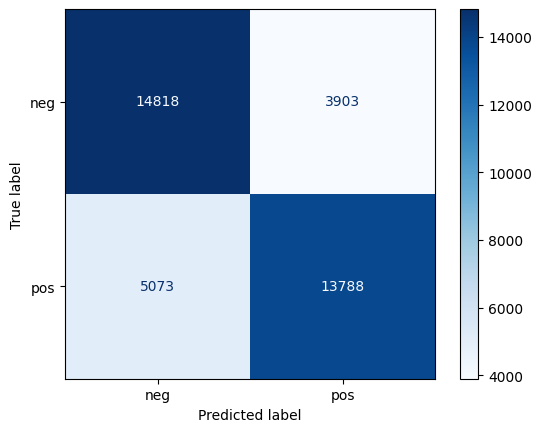

ROC-AUC: 0.8509   |   PR-AUC: 0.8478


In [17]:
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve, auc
)
import matplotlib.pyplot as plt

y_true = df["label"]
y_pred = df["predicted_label"]
y_prob = df["prob_positive"]          # probability of class 1

print(classification_report(y_true, y_pred, target_names=["negative","positive"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["neg","pos"])
disp.plot(cmap="Blues", values_format="d")
plt.show()

# ROC-AUC  & PR-AUC
roc_auc = roc_auc_score(y_true, y_prob)
pr_auc  = auc(*precision_recall_curve(y_true, y_prob)[:2][::-1])
print(f"ROC-AUC: {roc_auc:.4f}   |   PR-AUC: {pr_auc:.4f}")


In [18]:
# Confidence = max(probabilities)
df["confidence"] = df[["prob_negative","prob_positive"]].max(axis=1)

# (a) Very confident AND wrong
vc_wrong = df[(df["performance"]==0) & (df["confidence"]>=0.90)]
print(f"Very-confident mistakes: {len(vc_wrong)}")
display(vc_wrong[["review","label","predicted_label","prob_negative","prob_positive","confidence"]]
        .sort_values("confidence", ascending=False).head(20))

# (b) Very confident AND right (sanity check for overconfidence)
vc_right = df[(df["performance"]==1) & (df["confidence"]>=0.90)]
print(f"Very-confident hits: {len(vc_right)}")

# (c) Least confident predictions
low_conf = df.sort_values("confidence").head(20)


Very-confident mistakes: 3471


,review,label,predicted_label,prob_negative,prob_positive,confidence
33354,butter battle is an entertaining story about t...,0,1,0.000759,0.999242,0.999242
16068,with the plethora of repetitive and derivative...,0,1,0.000854,0.999146,0.999146
10599,if you have ever wanted to know more about cab...,0,1,0.001006,0.998994,0.998994
32061,this is a great movie for first time ninjas wh...,0,1,0.001006,0.998994,0.998994
35050,"this movie is dated in so many ways, its sensa...",0,1,0.001007,0.998993,0.998993
4921,isaac florentine has made some of the best wes...,0,1,0.001027,0.998973,0.998973
34629,an excellent performance by alix elias highlig...,0,1,0.001028,0.998972,0.998972
4124,ayone who whines about how this movie was crap...,1,0,0.998947,0.001053,0.998947
18317,once in a great while i will watch a movie tha...,0,1,0.001129,0.998871,0.998871
21773,this is one of crichtons best books. the chara...,0,1,0.001146,0.998854,0.998854


Very-confident hits: 20947


In [19]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1s = [f1_score(y_true, (y_prob>t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
print(f"Best F1 threshold: {best_t:.2f} (F1={max(f1s):.4f})")


Best F1 threshold: 0.15 (F1=0.7784)


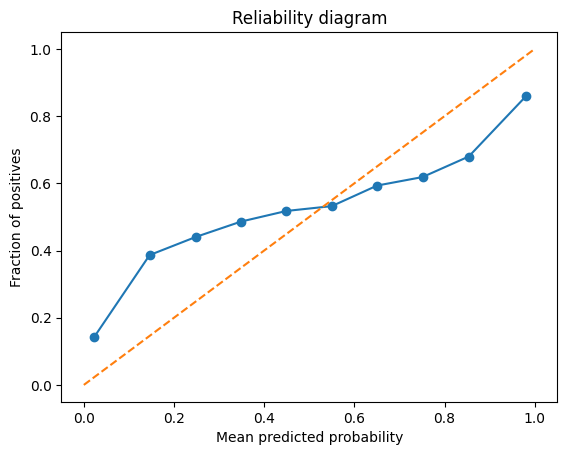

In [20]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability diagram")
plt.show()


# Clustering

In [3]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# File Paths
sentiment_file_path = os.path.join('bert_initial_test_predictions.csv')
current_file_path = os.path.join('full_embeddings.parquet')

# Load only the required columns
embeddings_df = pd.read_parquet(current_file_path)
sentiment_df = pd.read_csv(sentiment_file_path, usecols=['performance'])


# Ensure matching lengths
if len(embeddings_df) != len(sentiment_df):
    raise ValueError("The number of rows in embeddings and sentiment files do not match!")

# Add sentiment back to embeddings
embeddings_df['performance'] = sentiment_df['performance']


# Expand the embedding list into separate columns
embedding_features = pd.DataFrame(embeddings_df['embedding'].tolist(), index=embeddings_df.index)

# Display the resulting DataFrame
print(embedding_features.head())


       0         1         2         3         4         5         6     \
0  0.009761  0.020838  0.007701  0.019403 -0.009721 -0.022931  0.042229   
1 -0.009143  0.077880  0.018788  0.012133 -0.062808 -0.014750  0.055041   
2 -0.043995  0.057969 -0.030441  0.033379  0.028565  0.011233  0.014554   
3 -0.018539  0.056989 -0.035877  0.013296  0.021573 -0.051396  0.045160   
4 -0.002868  0.019771 -0.077011  0.000339 -0.039983 -0.001930  0.062075   

       7         8         9     ...      1526      1527      1528      1529  \
0  0.018666 -0.017547 -0.026222  ... -0.033699 -0.039623 -0.017653 -0.000470   
1  0.022441 -0.023058  0.002363  ...  0.047196 -0.015008 -0.011928 -0.012301   
2  0.029651 -0.006262 -0.016504  ...  0.001408  0.001357 -0.036490 -0.042489   
3  0.023265  0.014443  0.040938  ... -0.018917  0.029837 -0.013485 -0.012101   
4  0.067365 -0.028574 -0.012200  ... -0.001137  0.002659 -0.003938 -0.037027   

       1530      1531      1532      1533      1534      1535  
0 -0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

X = embedding_features 
# Converting column names to str
X.columns = X.columns.astype(str)

# Fit KMeans++ with 50 clusters
n_clusters = 50
clusterer = KMeans(n_clusters=n_clusters, n_init=10, init='k-means++', random_state=10)
cluster_labels = clusterer.fit_predict(X)

In [ ]:
# Load the train_set_predictions.csv file
df = pd.read_csv(sentiment_file_path)

# Ensure the number of rows matches
if len(df) != len(cluster_labels):
    raise ValueError(f"Number of rows in DataFrame ({len(df)}) does not match number of cluster labels ({len(cluster_labels)}).")

# Append cluster labels as a new column
df['cluster'] = cluster_labels

# Save the updated DataFrame back to the same file (or a new file if preferred)
df.to_csv('bert_clustered_initial_test_predictions.csv', index=False)

# Confirm the operation
print(f"Updated DataFrame with {len(df)} rows saved to 'imdb/test_set_predictions.csv' with new 'cluster_label' column.")

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
import umap

# 1. Load data
sentiment_file_path  = 'bert_initial_test_predictions.csv'
embeddings_file_path = 'full_embeddings.parquet'

sentiment_df  = pd.read_csv(sentiment_file_path)
embeddings_df = pd.read_parquet(embeddings_file_path)

if len(embeddings_df) != len(sentiment_df):
    raise ValueError("Row count mismatch between embeddings and sentiment files!")

# merge and expand
embeddings_df['performance'] = sentiment_df['performance']
X = pd.DataFrame(embeddings_df['embedding'].tolist(), index=embeddings_df.index)
X.columns = X.columns.astype(str)
print("Raw embedding shape:", X.shape)

# 2. UMAP reduction to 10D
reducer = umap.UMAP(
    n_components = 10,
    n_neighbors  = 30,
    min_dist     = 0.1,
    metric       = 'cosine',
    # random_state = 42
)
X_reduced = reducer.fit_transform(X)
print("UMAP projection shape:", X_reduced.shape)

# 3. K-Means clustering in reduced space
n_clusters = 50
clusterer  = KMeans(
    n_clusters   = n_clusters,
    init         = 'k-means++',
    n_init       = 10,
    random_state = 10
)
labels = clusterer.fit_predict(X_reduced)

# 4. Compute and print metrics
inertia = clusterer.inertia_
sil     = silhouette_score(X_reduced, labels)
ch      = calinski_harabasz_score(X_reduced, labels)
db      = davies_bouldin_score(X_reduced, labels)

print(f"\nK-Means results (n_clusters={n_clusters}):")
print(f" • Inertia:               {inertia:,.0f}")
print(f" • Silhouette Score:      {sil:.4f}")
print(f" • Calinski–Harabasz idx: {ch:,.0f}")
print(f" • Davies–Bouldin idx:    {db:.4f}")

# 5. Save clusters back to CSV
out_df = sentiment_df.copy()
out_df['cluster'] = labels
out_df.to_csv('bert_clustered_with_umap.csv', index=False)
print(f"\nSaved {len(out_df)} rows with cluster labels to 'bert_clustered_with_umap.csv'")


Raw embedding shape: (37582, 1536)


/home/saarbu/.conda/envs/my_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP projection shape: (37582, 10)

K-Means results (n_clusters=50):
 • Inertia:               22,773
 • Silhouette Score:      0.2809
 • Calinski–Harabasz idx: 6,763
 • Davies–Bouldin idx:    1.1270

Saved 37582 rows with cluster labels to 'bert_clustered_with_umap.csv'


In [11]:
%%time
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
import umap

# 1. Load data
sentiment_file_path  = 'bert_initial_test_predictions.csv'
embeddings_file_path = 'full_embeddings.parquet'

sentiment_df  = pd.read_csv(sentiment_file_path, usecols=['performance'])
embeddings_df = pd.read_parquet(embeddings_file_path)

if len(embeddings_df) != len(sentiment_df):
    raise ValueError("Row count mismatch between embeddings and sentiment files!")

# merge and expand
embeddings_df['performance'] = sentiment_df['performance']
X = pd.DataFrame(embeddings_df['embedding'].tolist(), index=embeddings_df.index)
X.columns = X.columns.astype(str)
print("Raw embedding shape:", X.shape)

# 2. UMAP reduction to 10D
reducer = umap.UMAP(
    n_components = 10,
    n_neighbors  = 30,
    min_dist     = 0.1,
    metric       = 'cosine',
    # random_state = 42
)
X_reduced = reducer.fit_transform(X)
print("UMAP projection shape:", X_reduced.shape)

# 3. K-Means clustering in reduced space
n_clusters = 100
clusterer  = KMeans(
    n_clusters   = n_clusters,
    init         = 'k-means++',
    n_init       = 10,
    random_state = 10
)
labels = clusterer.fit_predict(X_reduced)

# 4. Compute and print metrics
inertia = clusterer.inertia_
sil     = silhouette_score(X_reduced, labels)
ch      = calinski_harabasz_score(X_reduced, labels)
db      = davies_bouldin_score(X_reduced, labels)

print(f"\nK-Means results (n_clusters={n_clusters}):")
print(f" • Inertia:               {inertia:,.0f}")
print(f" • Silhouette Score:      {sil:.4f}")
print(f" • Calinski–Harabasz idx: {ch:,.0f}")
print(f" • Davies–Bouldin idx:    {db:.4f}")

# # 5. Save clusters back to CSV
# out_df = sentiment_df.copy()
# out_df['cluster'] = labels
# out_df.to_csv('bert_clustered_with_umap.csv', index=False)
# print(f"\nSaved {len(out_df)} rows with cluster labels to 'bert_clustered_with_umap.csv'")


Raw embedding shape: (37582, 1536)


/home/saarbu/.conda/envs/my_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP projection shape: (37582, 10)

K-Means results (n_clusters=100):
 • Inertia:               14,103
 • Silhouette Score:      0.2960
 • Calinski–Harabasz idx: 5,619
 • Davies–Bouldin idx:    1.0433
CPU times: user 1min 57s, sys: 1min 9s, total: 3min 7s
Wall time: 1min 33s


In [9]:
%%time
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
import umap

# 1. Load data
sentiment_file_path  = 'bert_initial_test_predictions.csv'
embeddings_file_path = 'full_embeddings.parquet'

sentiment_df  = pd.read_csv(sentiment_file_path, usecols=['performance'])
embeddings_df = pd.read_parquet(embeddings_file_path)

if len(embeddings_df) != len(sentiment_df):
    raise ValueError("Row count mismatch between embeddings and sentiment files!")

# merge and expand
embeddings_df['performance'] = sentiment_df['performance']
X = pd.DataFrame(embeddings_df['embedding'].tolist(), index=embeddings_df.index)
X.columns = X.columns.astype(str)
print("Raw embedding shape:", X.shape)

# 2. UMAP reduction to 10D
reducer = umap.UMAP(
    n_components = 30,
    n_neighbors  = 30,
    min_dist     = 0.1,
    metric       = 'cosine',
    # random_state = 42
)
X_reduced = reducer.fit_transform(X)
print("UMAP projection shape:", X_reduced.shape)

# 3. K-Means clustering in reduced space
n_clusters = 50
clusterer  = KMeans(
    n_clusters   = n_clusters,
    init         = 'k-means++',
    n_init       = 10,
    random_state = 10
)
labels = clusterer.fit_predict(X_reduced)

# 4. Compute and print metrics
inertia = clusterer.inertia_
sil     = silhouette_score(X_reduced, labels)
ch      = calinski_harabasz_score(X_reduced, labels)
db      = davies_bouldin_score(X_reduced, labels)

print(f"\nK-Means results (n_clusters={n_clusters}):")
print(f" • Inertia:               {inertia:,.0f}")
print(f" • Silhouette Score:      {sil:.4f}")
print(f" • Calinski–Harabasz idx: {ch:,.0f}")
print(f" • Davies–Bouldin idx:    {db:.4f}")

# # 5. Save clusters back to CSV
# out_df = sentiment_df.copy()
# out_df['cluster'] = labels
# out_df.to_csv('bert_clustered_with_umap.csv', index=False)
# print(f"\nSaved {len(out_df)} rows with cluster labels to 'bert_clustered_with_umap.csv'")


Raw embedding shape: (37582, 1536)


/home/saarbu/.conda/envs/my_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP projection shape: (37582, 30)

K-Means results (n_clusters=50):
 • Inertia:               22,647
 • Silhouette Score:      0.2834
 • Calinski–Harabasz idx: 6,810
 • Davies–Bouldin idx:    1.0758
CPU times: user 2min 27s, sys: 1min 21s, total: 3min 48s
Wall time: 1min 56s
